<a href="https://colab.research.google.com/github/rfps09/Monitoria/blob/main/SemanaAcademica/SemanaAcademicaIris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rede neural para classificação de iris

Carregando e separando os dados, em 80% para treino e 20% para teste, 10% dos 80% vão para validação

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

data = np.genfromtxt('drive/MyDrive/TensorFlow/DataSets/iris.data', delimiter=',')
data = np.delete(data,-1,axis=1)
classe = np.genfromtxt('drive/MyDrive/TensorFlow/DataSets/iris.data', delimiter=',', dtype=str,usecols=-1)
classe = np.unique(classe,return_inverse=1)[1]

data_treino, data_teste, classe_treino, classe_teste = train_test_split(data,classe,test_size=0.2, random_state=123, stratify=classe)

classe_treino_onehot = to_categorical(classe_treino)

Criando uma classe EarlyStopping

In [26]:
import numpy as np
from tensorflow.keras.callbacks import Callback

class EarlyStoppingAtBestMetric(Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0, metric='loss'):
        super().__init__()
        self.patience = patience
        self.best_weights = None
        self.metric = metric

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.metric)
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

Criando a rede neural

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_model(numInput,numClasses):
    model = Sequential()
    model.add(Dense(20,activation='tanh',input_dim=numInput))
    model.add(Dense(numClasses,activation='softmax'))
    model.compile('Adam','categorical_crossentropy',metrics=['categorical_accuracy','Precision'])

    return model

model = create_model(4,3)

history = model.fit(
    data_treino,
    classe_treino_onehot,
    epochs=500,
    validation_split=0.1,
    callbacks=[EarlyStoppingAtBestMetric(patience=20,metric='val_loss')]
)

Epoch 1/500
4/4 [==============================] - 1s 78ms/step - loss: 1.2519 - categorical_accuracy: 0.3241 - precision: 0.3465 - val_loss: 1.1405 - val_categorical_accuracy: 0.4167 - val_precision: 0.4545
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: 1.1938 - categorical_accuracy: 0.3241 - precision: 0.3718 - val_loss: 1.1009 - val_categorical_accuracy: 0.4167 - val_precision: 0.1667
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 1.1367 - categorical_accuracy: 0.3241 - precision: 0.2979 - val_loss: 1.0668 - val_categorical_accuracy: 0.4167 - val_precision: 0.0000e+00
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 1.0893 - categorical_accuracy: 0.3241 - precision: 0.1250 - val_loss: 1.0372 - val_categorical_accuracy: 0.4167 - val_precision: 0.0000e+00
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 1.0469 - categorical_accuracy: 0.3241 - precision: 0.0000e+00 - val_loss: 1.0119 - val_c

Modelo da rede neural

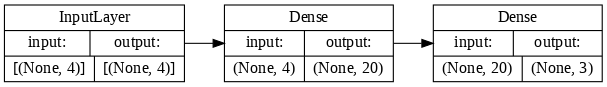

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(model,show_shapes=True,show_layer_names=False,rankdir="LR",dpi=80)

Gráficos

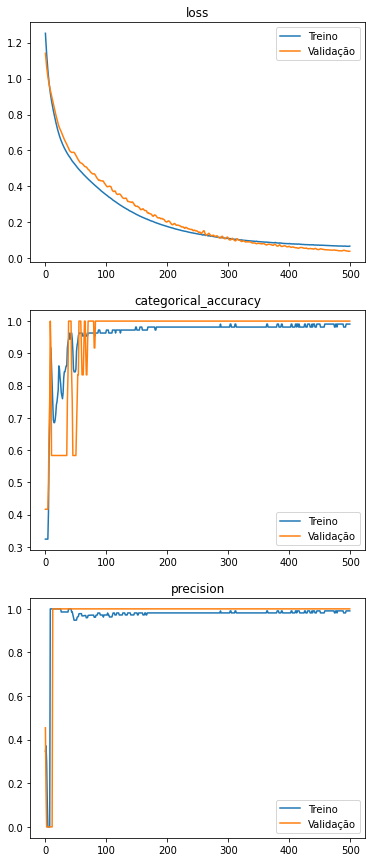

In [29]:
import matplotlib.pyplot as plt

def plot_metrics(map):
    val_data = True if 'val_loss' in map.history.keys() else False
    
    tam = len(map.history.keys())
    legendas = ['Treino']
    if val_data:
        tam = tam//2
        legendas.append('Validação')

    fig,axes = plt.subplots(tam,1,figsize=(6,tam*5))

    count = 0
    for key in map.history.keys():
        if key.startswith('val_'):
            continue
        axes[count].plot(map.history[key])
        if val_data:
            axes[count].plot(map.history['val_'+key])
        axes[count].set_title(key)
        axes[count].legend(legendas)
        count+=1

plot_metrics(history)

Testando a rede neural

In [30]:
classe_predita_onehot = model.predict(data_teste)
classe_predita = classe_predita_onehot.argmax(axis=1)

1/1 [==============================] - 0s 40ms/step


Matriz de confusão

In [31]:
from sklearn.metrics import confusion_matrix

matriz_confusao = confusion_matrix(classe_teste, classe_predita)
print(matriz_confusao)

[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


Métricas

In [32]:
from sklearn.metrics import classification_report

print(classification_report(classe_teste, classe_predita, digits=5,zero_division=1))

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        10
           1    1.00000   0.90000   0.94737        10
           2    0.90909   1.00000   0.95238        10

    accuracy                        0.96667        30
   macro avg    0.96970   0.96667   0.96658        30
weighted avg    0.96970   0.96667   0.96658        30



Salvar modelo treinado

In [33]:
model.save('drive/MyDrive/TensorFlow/Models/Iris/current_model')

Carregar o modelo salvo

In [34]:
from tensorflow.keras.models import load_model

model = load_model('drive/MyDrive/TensorFlow/Models/Iris/current_model')